In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

## toy data
$$
y = 5 x - 3 + \epsilon
$$
where $\epsilon \sim N(0, 2)$ as known.

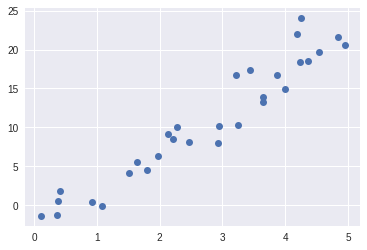

In [2]:
def toy_data():
    x = np.random.uniform(0, 5, 30)
    y = 5 * x - 3 + np.random.normal(0, 2, 30)
    return x, y
x_np, y_np = toy_data()

plt.plot(x_np, y_np, "o")

## make model
We build statistical model as below.

$$
\begin{align}
a \sim N(0, 10) \\
b \sim N(0, 10) \\
y \sim N(ax+b, 2) \\
\end{align}
$$

We want to know the parameters $a$ and $b$ through posterior $p(\cdot \mid x, y)$ from MCMC.

In [5]:
x = tf.convert_to_tensor(
    x_np,
    dtype=tf.float32
)

y = tf.convert_to_tensor(
    y_np,
    dtype=tf.float32
)


Root = tfd.JointDistributionCoroutine.Root
def model():
    a = yield Root(tfd.Normal(loc=0, scale=10.))
    b = yield Root(tfd.Normal(loc=0, scale=10.))
    y = yield tfd.Normal(loc=a * x + b, scale=tf.constant(2.0))



## joint distribution
First, we prepare joint distribution $p(y,a,b\mid x)$. (Note, $x$ is given by out of model.)

In [6]:
joint = tfd.JointDistributionCoroutine(model)
sample = joint.sample()

In [7]:
sample

(<tf.Tensor: id=28, shape=(), dtype=float32, numpy=5.6546383>,
 <tf.Tensor: id=53, shape=(), dtype=float32, numpy=0.31189847>,
 <tf.Tensor: id=79, shape=(30,), dtype=float32, numpy=
 array([17.584944  , 25.201288  , 15.490198  ,  5.165868  ,  0.29396194,
        24.354269  ,  9.953471  , 14.415665  , 14.054543  , 12.14949   ,
         9.686166  ,  0.57181025, 14.72935   , -1.1694822 , 18.234703  ,
         9.928075  , 25.887444  , 23.85184   , 23.123177  , 21.094206  ,
         8.772196  , 13.453693  , 26.287586  ,  6.447795  , 19.30827   ,
        20.760162  , 14.5332985 , 22.894247  ,  4.7184334 , 28.569122  ],
       dtype=float32)>)

## plot before training
That initial model can generate samples $a, b, y$. (However it does not match to data.)

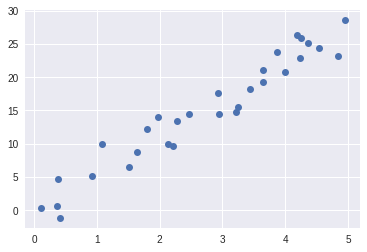

In [8]:
plt.plot(x.numpy(), sample[-1].numpy(), "o")

## likelihood
A generated sample likelihood can be caluclated each data point.

In [9]:
joint.log_prob(sample)

<tf.Tensor: id=117, shape=(30,), dtype=float32, numpy=
array([ -8.277493,  -8.221734,  -9.475068,  -8.234814,  -8.262238,
        -8.547427,  -8.965708,  -9.013992,  -9.039732,  -8.551022,
        -9.443696,  -8.62281 , -10.029757,  -9.994436,  -8.507306,
        -9.745901,  -8.516852,  -8.572927, -10.799183,  -8.218836,
        -8.29117 ,  -8.223557,  -8.871852,  -8.91931 ,  -8.539169,
        -8.812513,  -8.222011,  -8.44175 ,  -8.872479,  -8.223422],
      dtype=float32)>

## posterior distribution
MCMC need unnormalized posterior distribution model to calculate energy.

It is maked easily. We have joint distributon $p(y,a,b\mid x)$, so we give this distributon know data $x, y$.
The joint distribution is given $x$ model, therefore we keed to give y to `joint.log_prob`.
The $a$ and $b$ is given through `unnormalized_log_posterior` function lazyly.

In [11]:
def unnormalized_log_posterior(a, b):
    return tf.reduce_mean(joint.log_prob([a, b, y]))

## MCMC
We use popular MCMC method "NUTS" which kind of gradient MCMC.

In [12]:
kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=unnormalized_log_posterior,
      step_size=0.1,
)

@tf.function()
def run_chain():
    init_state = list(joint.sample()[:-1]) # a, b
    chains_states, kernels_results = tfp.mcmc.sample_chain(
        num_results=1000,
        num_burnin_steps=300,
        current_state=init_state,
        kernel=kernel
    )
    return chains_states, kernels_results

# Sample from posterior distribution and get diagnostic
chain_states, kernel_results = run_chain()

/home/sano/anaconda3/envs/COM/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


## result
A `chain_states` have posterior of $a$ and $b$ with MCMC sampler.

In [14]:
a, b = (
    chain_states[0],
    chain_states[1],
)

(array([  5.,  17.,  94., 127., 206., 214., 179.,  92.,  50.,  16.]),
 array([0.9572996, 1.7070127, 2.4567256, 3.2064385, 3.9561515, 4.7058644,
        5.455578 , 6.205291 , 6.9550037, 7.7047167, 8.45443  ],
       dtype=float32),
 <a list of 10 Patch objects>)

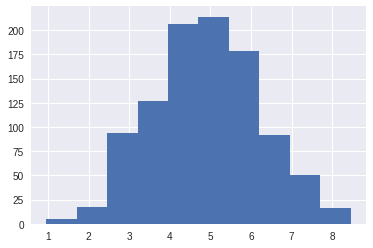

In [29]:
plt.hist(a)

(array([  1.,  10.,  52., 147., 221., 209., 175., 130.,  53.,   2.]),
 array([-16.379251 , -13.7673435, -11.155436 ,  -8.543528 ,  -5.9316196,
         -3.3197117,  -0.7078037,   1.9041042,   4.516012 ,   7.12792  ,
          9.739828 ], dtype=float32),
 <a list of 10 Patch objects>)

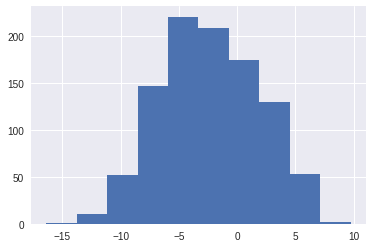

In [30]:
plt.hist(b)

## EAP estimation
We have posterior $p(a \mid x, y)$ and $p(b \mid x, y)$, therefore we can get $\mathbb E _ {p(a \mid x, y)}[a]$ and $\mathbb E _ {p(b \mid x, y)}[b]$ parameters. This is called EAP estimation.

In [31]:
a_mean = tf.reduce_mean(a)
b_mean = tf.reduce_mean(b)

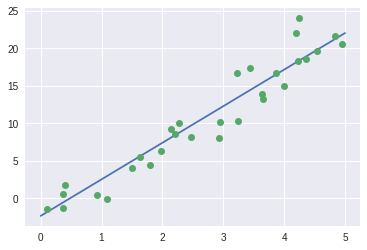

In [36]:
x_new = tf.convert_to_tensor(np.linspace(0, 5, 100), dtype=tf.float32)

y_new = a_mean * x_new + b_mean

plt.plot(x_new, y_new)
plt.plot(x, y, "o")

## Bayes prediction distribution
We can caluclate bayes predictive distribution.

$$
p(y _ {new} \mid x _ {new}, x, y) = \int _ {a, b} p(y _ {new}\mid x _ {new}, a, b)p(a, b \mid x, y)dadb
$$

We use montecalro sampler represented as below.

$$
p(y _ {new} \mid x _ {new}, x, y) \sim \frac{1}{N}\sum _ {a _ i, b _ i} ^ N p(y _ {new}\mid x _ {new}, a _ i, b _ i)
$$

It is apporoximation of "the expected value of the statistical model $p(y _ {new}\mid x _ {new}, a _ i, b _ i)$ by parameter's posterior".

In [43]:
def statistical_model(a, b):
    return a * x_new + b

tfp.monte_carlo.expectation(
    f=statistical_model,
    samples=[a, b]
)

TypeError: statistical_model() missing 1 required positional argument: 'b'